## Predictive Model

### Task 0 Setup

In [ ]:
getwd() # show current working directory

#### R Packages

In [1]:
install.packages("glmnet") #install other R packages if necessary


The downloaded binary packages are in
	/var/folders/0p/wklr8kqj0h52vzxckdpz9xhc0000gn/T//RtmptYOrty/downloaded_packages


In [2]:
###Task 0###
#Load necessary packages
library(caret)
library(pls)
library(gbm)
library("performance")
library(car)
library(glmnet)

Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘pls’


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:stats’:

    loadings


Loaded gbm 2.1.8

Loading required package: carData

Loading required package: Matrix

Loaded glmnet 4.1-3



#### Data Preparation

In [3]:
###Task 0###
#Load dataset
dat=read.csv("data.csv")
attach(dat)  # make dat in the search path of R

#Standardization is required before performing regression or boosted tree model as the 49 covariates are on different scales 
#Standardization means dividing a covariate by its sample standard deviation

#Creating Standardization function
standardize = function(x){
  z <- x / sd(x)
  return(z)
}

#Standardization
dat[3:4]<-apply(dat[3:4], 2, standardize) #Covariate: VOL, RETC
dat[6:52]<-apply(dat[6:52], 2, standardize) #Covariate: sprtrn, SPREAD, OSC, CAPEI, bm, pe_op_basic, pe_exi, ps, pcf, dpr, npm, opmad, roa, roe, efftax, totdebt_invcap, capital_ratio, int_totdebt, cash_lt, invt_act, rect_act, debt_ebitda, short_debt, ocf_lct, cash_debt, fcf_ocf, de_ratio, intcov_ratio, cash_ratio, quick_ratio, curr_ratio, cash_conversion, inv_turn, at_turn, sale_invcap, sale_equity, sale_nwc, rd_sale, adv_sale, staff_sale, ptb, PEG_trailing, divyield, b_mkt, alpha, ivol, tvol

#For double checking only
#library(dplyr)
#dat %>% summarise_if(is.numeric, sd) #Show all SD of numeric variables in the dataset


### Task 1 OLS Regression

#### OLS Regression Without Cross Validation

After performing OLS regression using all covariates, the model result and its performance are as follows.

To check if this model provide a good fit, there are different indices, for example, residuals, residual standard error, AIC, BIC, adjusted R ^2 and RMSE, etc. We can see that there is still room for improvement. 

Although some indices (such small figures of residual, residual standard error, AIC, BIC and test MSE) implies the model fitted the data well, the adjusted R^2 is quite small (i.e. 0.02557666), which states the model poorly fitted the data. We also know that most of the covariates are not significant for the modeling as the p-values of most of the covariates are larger than 0.1. Moreover, the added variable plots show that the covariates are mostly not linearly related to the dependent variable (which is "RETN" - Return of the Next Month in this case) and there are quite a lot of outliers. 

Therefore, we will build predictive model using several regression approaches in the following section and see if the model performance can be further improved.

[1] "--------------------------OLS Regression Summary--------------------------"



Call:
lm(formula = RETN ~ ., data = adj_dat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.255979 -0.035680  0.002473  0.036511  0.258066 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -2.256e-02  1.668e-02  -1.353 0.176200    
VOL             -1.839e-03  1.182e-03  -1.556 0.119779    
RETC            -3.230e-03  1.227e-03  -2.633 0.008495 ** 
sprtrn          -4.766e-03  1.209e-03  -3.942 8.25e-05 ***
SPREAD           1.249e-03  1.110e-03   1.125 0.260643    
OSC              1.790e-04  1.011e-03   0.177 0.859462    
CAPEI           -2.649e-03  1.032e-03  -2.568 0.010280 *  
bm               6.816e-03  2.276e-03   2.995 0.002767 ** 
pe_op_basic      2.906e-03  1.107e-03   2.626 0.008670 ** 
pe_exi          -2.286e-04  1.115e-03  -0.205 0.837644    
ps               3.075e-03  2.147e-03   1.433 0.152073    
pcf             -2.005e-03  1.226e-03  -1.635 0.102116    
dpr             -1.059e-03  1.080e-03  -0.981 0.326521    

[1] "--------------------------Estimated Test MSE--------------------------"
[1] "OLS Regression (without CV): 0.00348251218890554"


,AIC,BIC,R2,R2_adjusted,RMSE,Sigma
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-10057.65,-9742.024,0.03884333,0.02557666,0.05901281,0.05942694


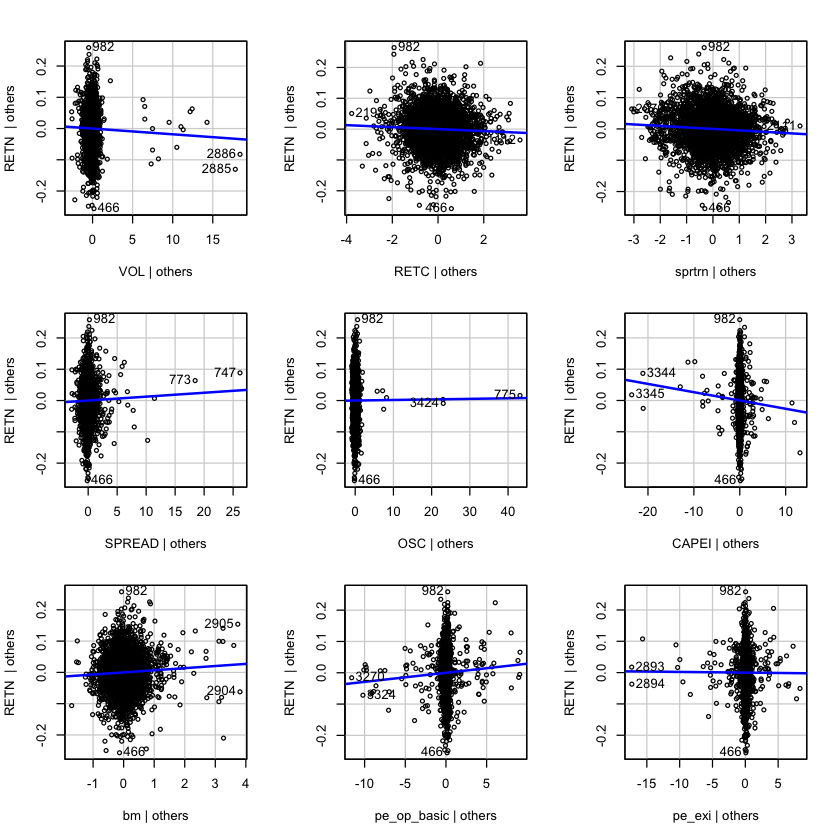

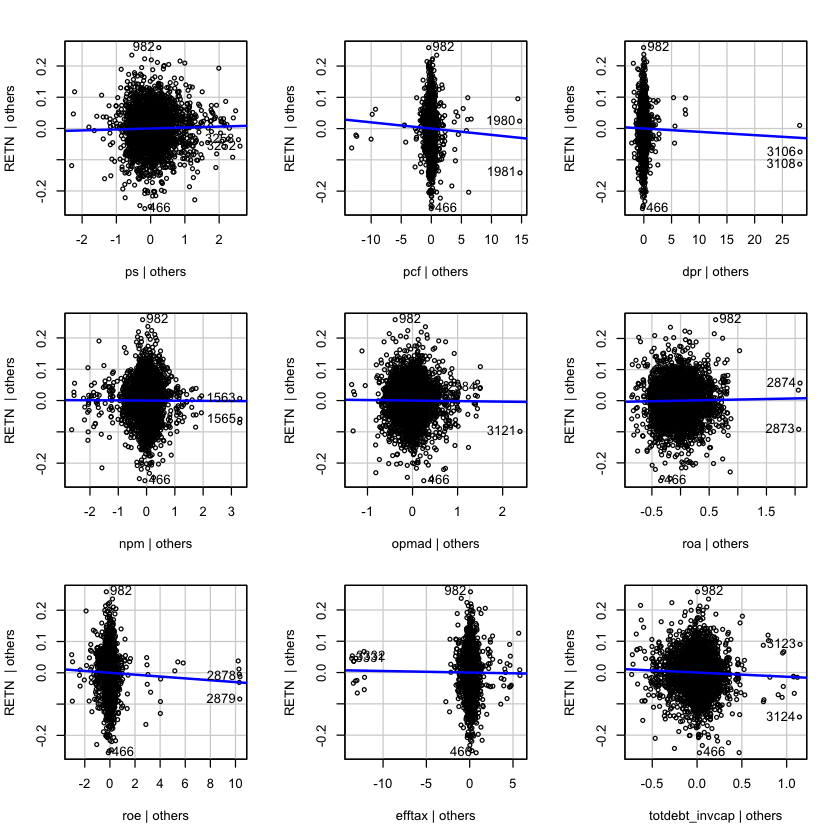

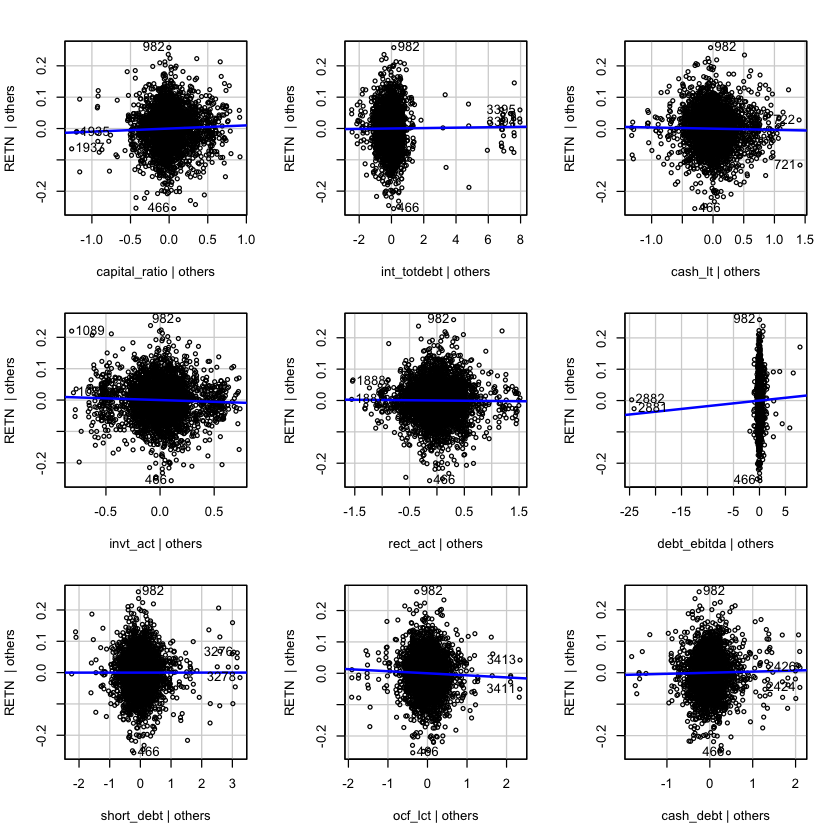

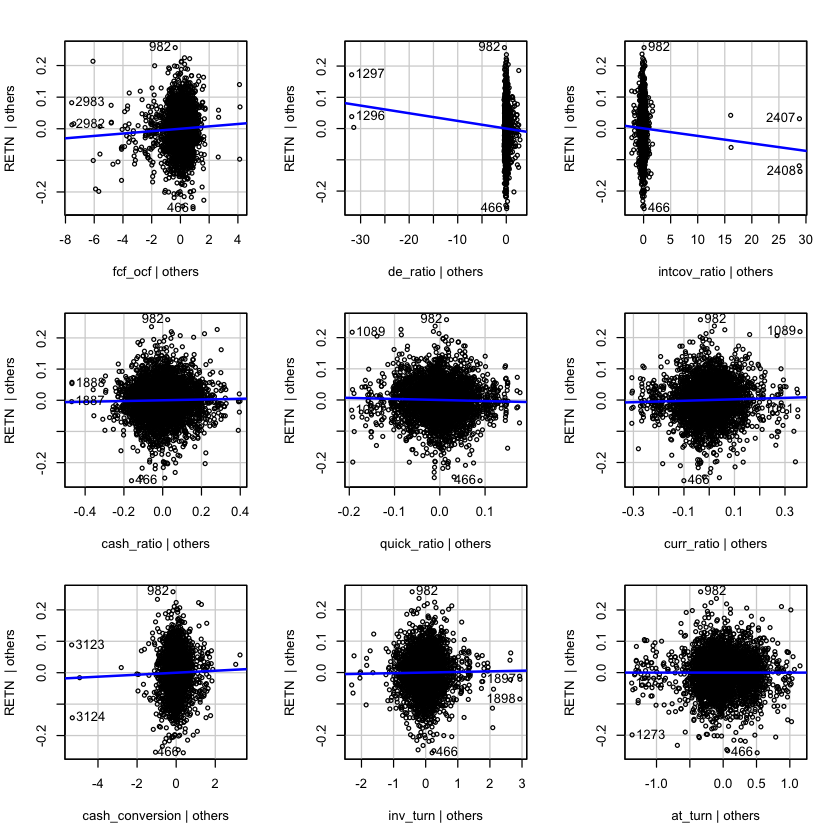

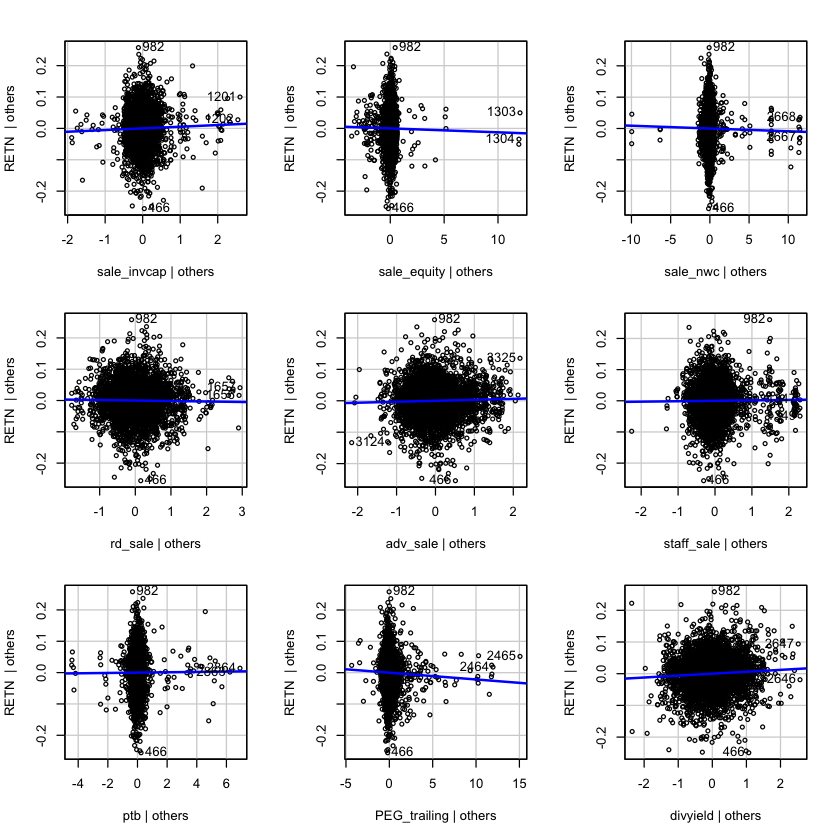

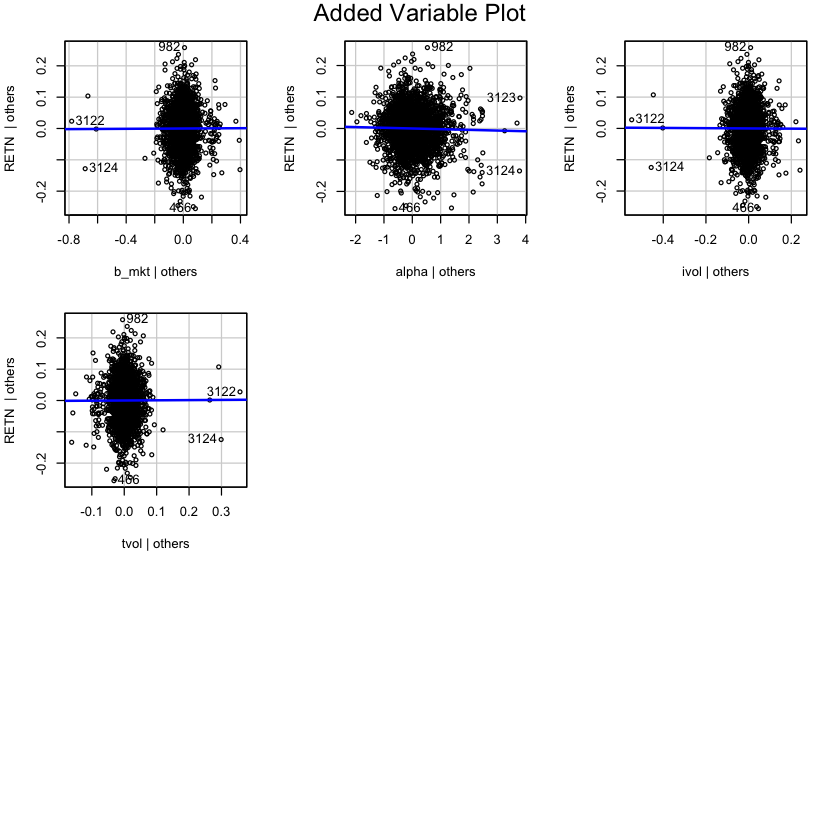

In [4]:
###Task 1a###
#Perform ordinary least squares (OLS) regression with all 49 covariates. 
adj_dat<-dat[3:52] #only remain response variable and 49 covariates
reg1=lm(RETN~.,data=adj_dat)

###Task 1b###
#Check if linear regression model provide a good fit 
print("--------------------------OLS Regression Summary--------------------------")
summary(reg1)

print("--------------------------Estimated Test MSE--------------------------")
TestMSE=as.numeric(model_performance(reg1)[5]^2)
print(paste0("OLS Regression (without CV): ", TestMSE))

#Indices of model performance for regression models.
model_performance(reg1)

#Added variable plots
avPlots(reg1,main='Added Variable Plot')


#### OLS Regression With Cross Validation

Here we will continue using OLS regression but with 10-fold cross validation.

One of the drawbacks for the previous model is using only one testing set and one training set. Under this model, the test MSE can vary greatly depending on which observations were used in the training and testing sets.

One way to avoid this problem is fitting the regression model several times using a different training and testing set each time, then calculating the test MSE to be the average of all of the test MSE’s. It is known as k-fold cross-validation. By using k-fold cross validation, it is more likely to obtain an unbiased estimate of the test MSE since different variations of training and testing sets are used each time.

Below is the result of OLS regression with 10-fold CV. For illustration purpose, we set seed = 1 to generate the same result every time. To compare with the previous model result, we will consider if the test MSE is decreased. The test MSE is increased from 0.00348251218890554 to 0.00361364521176696. Although the test MSE increased but not decreased, it is not necessary that this model is worse than the previous one. As mentioned, the test MSE of the model without cross validation can vary depending on the model training process. Using cross validation, it will deliver an unbiased test MSE.

In task 2, we will build model using other regression approaches, which are LASSO, PLS and boosted tree.

In [5]:
###Task 1c###
#OLS Regression: Test MSE estimated by the 10-fold CV
#Set seed to re-generate the same result
set.seed(1)

train.control=trainControl(method="cv",number=10)   # 10-fold CV
reg1_cv=train(RETN~., data=adj_dat, method="lm", trControl=train.control)

#Check if any significant improvements over OLS
#Result: Cross Validation
print("--------------------------Cross Validation Summary--------------------------")
print(reg1_cv)
reg1_cv$results

#Result: Test MSE
TestMSE_cv=as.numeric(reg1_cv$results[2])^2   # The estimated test MSE from CV

print("--------------------------Estimated Test MSE--------------------------")
print(paste0("OLS Regression (without CV): ", TestMSE))
print(paste0("OLS Regression: ", TestMSE_cv))


[1] "--------------------------Cross Validation Summary--------------------------"
Linear Regression 

3600 samples
  49 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 3240, 3240, 3240, 3240, 3240, 3240, ... 
Resampling results:

  RMSE       Rsquared    MAE       
  0.0601136  0.01578533  0.04611416

Tuning parameter 'intercept' was held constant at a value of TRUE


,intercept,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TRUE,0.0601136,0.01578533,0.04611416,0.001931619,0.01849878,0.001041196


[1] "--------------------------Estimated Test MSE--------------------------"
[1] "OLS Regression (without CV): 0.00348251218890554"
[1] "OLS Regression: 0.00361364521176696"


### Task 2 Other Regression Method

#### Least Absolute Shrinkage and Selection Operator (LASSO)

Here is the result of LASSO with 10-fold CV.
Below shows that the test MSE is decreased from 0.00361364521176696 to 0.00358066986142889. It implies that the model performance is improved over OLS regression with 10-fold CV.

[1] "LASSO Regression"
[1] "--------------------------Cross Validation Summary--------------------------"
[1] "Header of Cross Validation Output"


[1] "lambda"     "cvm"        "cvsd"       "cvup"       "cvlo"      
 [6] "nzero"      "call"       "name"       "glmnet.fit" "lambda.min"
[11] "lambda.1se" "index"

[1] "Estimated Test Error for each Lambda"


[1] 0.003625130 0.003622662 0.003617133 0.003612311 0.003608309 0.003605008
 [7] 0.003602273 0.003600019 0.003598054 0.003596208 0.003594196 0.003592415
[13] 0.003590764 0.003589002 0.003586819 0.003584318 0.003582555 0.003581309
[19] 0.003580670 0.003581017 0.003581817 0.003583020 0.003584663 0.003586741
[25] 0.003588721 0.003590554 0.003592260 0.003593802 0.003595240 0.003596605
[31] 0.003597860 0.003599003 0.003599945 0.003600863 0.003601913 0.003603063
[37] 0.003604144 0.003605219 0.003606209 0.003607003 0.003607602 0.003607894
[43] 0.003608005 0.003608201 0.003608664 0.003609247 0.003609761 0.003610194
[49] 0.003610684 0.003611106 0.003611471 0.003611852 0.003612190 0.003612478
[55] 0.003612662 0.003612809 0.003612977 0.003613151 0.003613186 0.003613221
[61] 0.003613201 0.003613141 0.003613111 0.003613113 0.003613129 0.003613155
[67] 0.003613183 0.003613209 0.003613235 0.003613269 0.003613306 0.003613345
[73] 0.003613408 0.003613462 0.003613525 0.003613569 0.003613637 0.003613711
[79] 0.003613766 0.003613835 0.003613895 0.003613952 0.003614007 0.003614051
[85] 0.003614089 0.003614123 0.003614155 0.003614185 0.003614212 0.003614234
[91] 0.003614255 0.003614273 0.003614289 0.003614308 0.003614324 0.003614339

[1] "Minimum Estimated Test Error"


[1] 0.00358067

[1] "Optimal Lamda with Minimum Estimated Test Error"


[1] 0.001201911

[1] "LASSO with the Optimal Lamda"


50 x 1 sparse Matrix of class "dgCMatrix"
                           s0
(Intercept)      1.881446e-03
VOL              .           
RETC            -1.764325e-03
sprtrn          -4.273224e-03
SPREAD           .           
OSC              .           
CAPEI           -1.525169e-03
bm               .           
pe_op_basic      1.133853e-03
pe_exi           .           
ps               .           
pcf             -1.687621e-04
dpr              .           
npm              .           
opmad            .           
roa              .           
roe              .           
efftax           .           
totdebt_invcap  -2.000681e-04
capital_ratio    .           
int_totdebt      .           
cash_lt          .           
invt_act         .           
rect_act        -9.150630e-05
debt_ebitda      .           
short_debt       .           
ocf_lct          .           
cash_debt        .           
fcf_ocf          1.528619e-03
de_ratio        -1.604818e-03
intcov_ratio    -1.035806e-0

[1] "--------------------------Estimated Test MSE--------------------------"
[1] "OLS Regression (without CV): 0.00348251218890554"
[1] "OLS Regression:     0.00361364521176696"
[1] "LASSO:              0.00358066986142889"


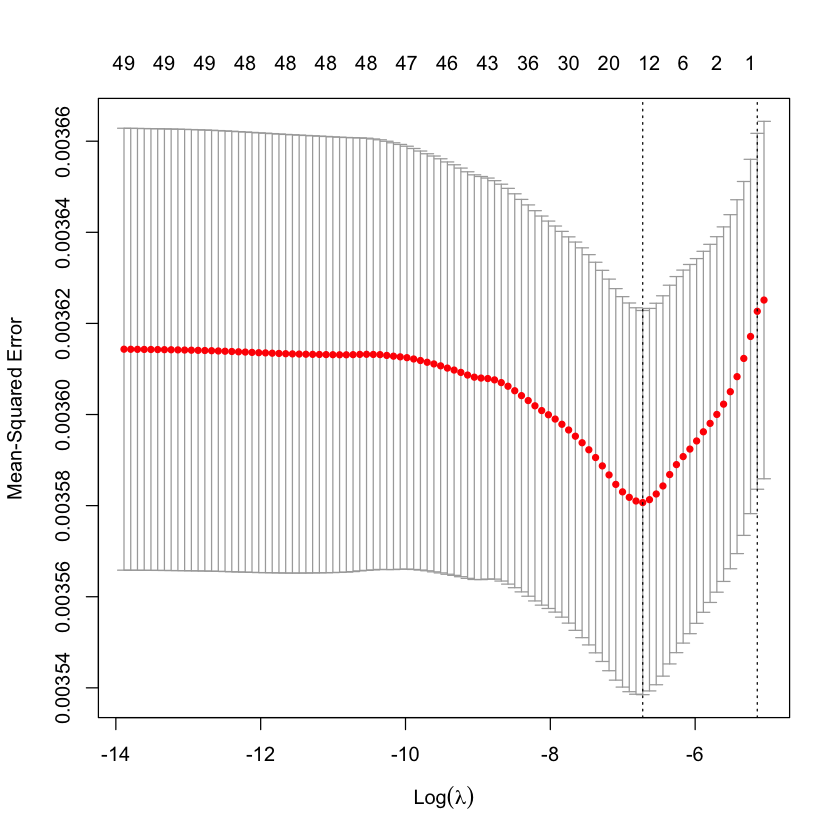

In [15]:
###Task 2a###
#LASSO: Perform regression (10-fold CV)

#Create the X matrix for regression (excluding the constant column)
x=model.matrix(RETN~.,adj_dat)[,-1] #adj_dat is the dataset with response variable and 49 covariates

#Remarks: 'model.matrix' creates a design (or model) matrix, 
#e.g., by expanding factors to a set of dummy variables (depending on the contrasts) and expanding interactions similarly.

#Create the Y vector for regression
y=RETN

#Use cross validation to find the best lambda for LASSO
set.seed(1)

#Default is 10-fold CV. You can change the setting using argument nfolds. 
#There's no need to specify the vector lambda. The function cv.glmnet will choose a sequence of lambda automatically. But you can specify your own lambda.
#Use alpha=0 for ridge regression

cv.out=cv.glmnet(x,y,nfolds=10,alpha=1)
plot(cv.out)

#Check if any significant improvements over OLS
#Result: Cross Validation
print("LASSO Regression")
print("--------------------------Cross Validation Summary--------------------------")

print('Header of Cross Validation Output')
names(cv.out)

#Remarks:
#Function 'cv.glmnet': Does k-fold cross-validation for glmnet, produces a plot, and returns a value for lambda (and gamma if relax=TRUE)
#Output - lambda: the sequence of penalty parameters. 
#Output - cvm: the estimated test error from CV for each lambda.
#Output - nzero: number of non-zero coefficients at each lambda.
#Output - lambda.min: the value of lambda that gives the smallest cvm.

#Type ?cv.glmnet to see the meanings of other variables in cv.out.

#List out the estiamted test error from cross validation for different lambda
print('Estimated Test Error for each Lambda')
cv.out$cvm

print('Minimum Estimated Test Error')
min(cv.out$cvm)

print('Optimal Lamda with Minimum Estimated Test Error')
bestlam=cv.out$lambda.min
bestlam

print('LASSO with the Optimal Lamda')
reg2_LASSO=glmnet(x,y,alpha=1,lambda=c(bestlam))
coef(reg2_LASSO)

#Result: Test MSE
TestMSE_LASSO=min(cv.out$cvm)   # The estimated test MSE from CV

print("--------------------------Estimated Test MSE--------------------------")
print(paste0("OLS Regression (without CV): ", TestMSE))
print(paste0(format("OLS Regression: ",width=20), TestMSE_cv))
print(paste0(format("LASSO: ",width=20), TestMSE_LASSO))


#### Partial Least Squares (PLS)

Here is the result of PLS with 10-fold CV.
Below shows that the test MSE is 0.0035856144 with 3 PLS components. It implies that the model performance is improved over OLS regression but not LASSO.

[1] "PLS"
[1] "--------------------------Cross Validation Summary--------------------------"
Data: 	X dimension: 3600 49 
	Y dimension: 3600 1
Fit method: kernelpls
Number of components considered: 49

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV         0.06021  0.06006  0.05992  0.05988  0.05989  0.05991  0.05994
adjCV      0.06021  0.06002  0.05989  0.05985  0.05986  0.05987  0.05990
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV     0.05994  0.05994  0.05998   0.05998   0.05999   0.05999   0.06000
adjCV  0.05990  0.05990  0.05994   0.05994   0.05994   0.05994   0.05994
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps  20 comps
CV      0.05997   0.05998   0.05997   0.05997   0.05995   0.05993   0.05993
adjCV   0.05992   0.05993   0.05992   0.05992   0.05990   0.05988   0.05989
       21 comps  22 comps  23 comps  24 comps  25 comps  26 comps  27 co

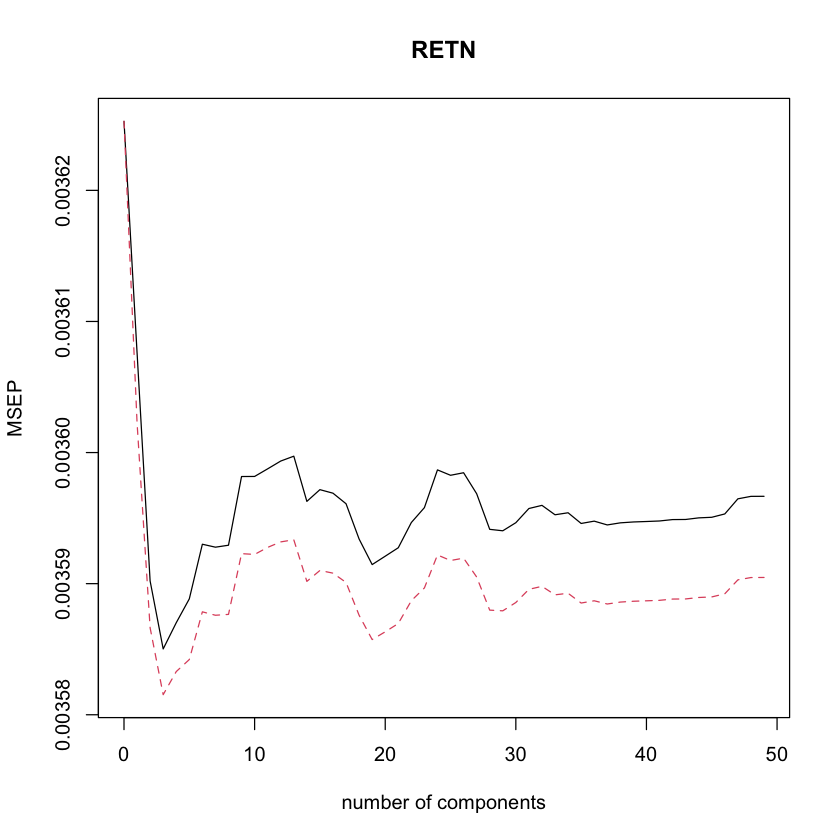

In [12]:
###Task 2b###
#PLS
#Set seed to re-generate the same result
set.seed(1)

#Perform regression with PLS (10-fold CV)
reg3_PLS=plsr(RETN~., data=adj_dat, scale=TRUE, validation="CV", segments=10) # Setting scale=TRUE standardizes every variable. CV uses 10-fold CV.

#Check if any significant improvements over OLS
#Result: Cross Validation
print("PLS")
print("--------------------------Cross Validation Summary--------------------------")
summary(reg3_PLS)

# Plotting the cross-validation results. MSEP refers to the MSE here. 
validationplot(reg3_PLS, val.type="MSEP")
TestMSE_PLS=0.05988^2   # The estimated test MSE from CV is sqrt of 0.05987 (Minimum Test RMSE with 3 PLS components) based on the graph
# Note that plsr() reports the root mean squared error; in order to obtain the usual MSE, we must square this quantity

print("--------------------------Estimated Test MSE--------------------------")
print(paste0("OLS Regression (without CV): ", TestMSE))
print(paste0(format("OLS Regression: ",width=20), TestMSE_cv))
print(paste0(format("LASSO: ",width=20), TestMSE_LASSO))
print(paste0(format("PLS: ",width=20), TestMSE_PLS))


#### Boosted Trees

Here is the result of boosted tree with 10-fold CV.
Below shows that the test MSE is decreased to 0.00342716119351072 (iteration 2148), which is the minimum among the regression models used in this project.

By definition, the smaller test MSE is, the better the model performance is. From the above result, we can see that there are significant improvements of other regression models over OLS (with 10-fold CV) as their test MSE are dropped. Boosted Tree is the best regression method among the models.

[1] "Boosted Trees"
[1] "--------------------------Cross Validation Summary--------------------------"


[1] 2148

[1] "--------------------------Estimated Test MSE--------------------------"
[1] "OLS Regression (without CV): 0.00348251218890554"
[1] "OLS Regression:     0.00361364521176696"
[1] "LASSO:              0.00358066986142889"
[1] "PLS:                0.0035856144"
[1] "Boosted Tree:       0.00342716119351072"


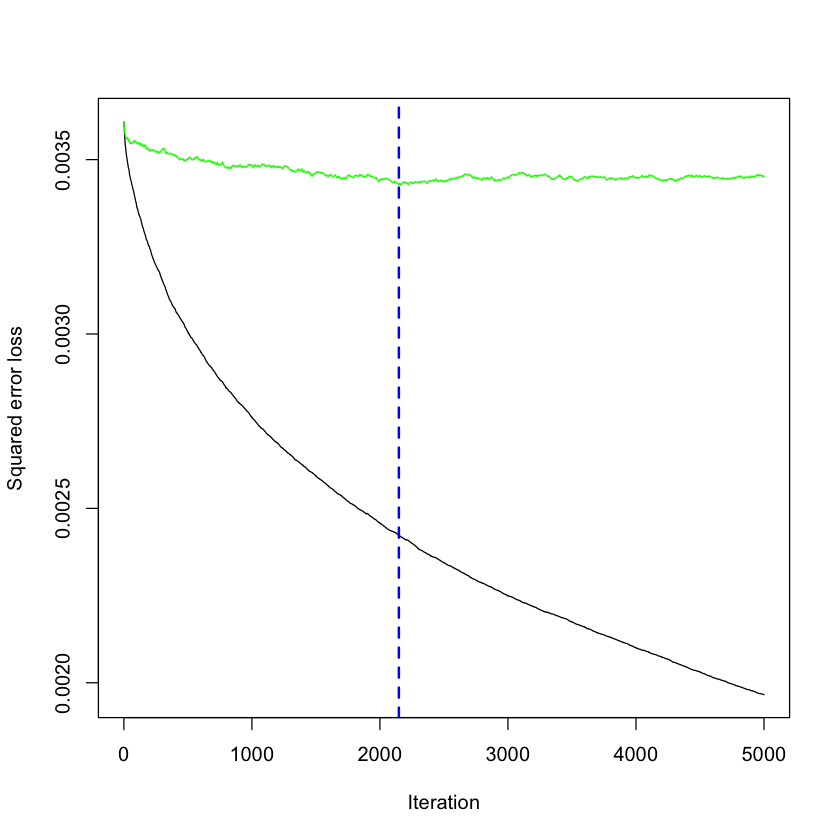

In [13]:
###Task 2c###
#Perform regression with boosted trees (10-fold CV)
#Set seed to re-generate the same result
set.seed(100)

# To solve regression problems, set distribution="gaussian".
# n.trees is the total number of iterations (i.e., the maximum value for B). 
# interaction.depth is d
# shrinkage is lambda. 0.1 is its default value

reg4_tree=gbm(RETN~., data=adj_dat, distribution="gaussian", n.trees =5000, interaction.depth=1, shrinkage=0.1, cv.folds=10)

#Check if any significant improvements over OLS
#Result: Cross Validation
print("Boosted Trees")
print("--------------------------Cross Validation Summary--------------------------")

#Result: Boosting
gbm.perf(reg4_tree, method="cv")

#Literation 2148 has the smallest cv error 

#Black line is for the training error
#Green line is for the test error
#Dashed blue line shows the optimal B

#Result: Test MSE
TestMSE_tree=reg4_tree$cv.error[which.min(reg4_tree$cv.error)] # The estimated test MSE from CV

print("--------------------------Estimated Test MSE--------------------------")
print(paste0("OLS Regression (without CV): ", TestMSE))
print(paste0(format("OLS Regression: ",width=20), TestMSE_cv))
print(paste0(format("LASSO: ",width=20), TestMSE_LASSO))
print(paste0(format("PLS: ",width=20), TestMSE_PLS))
print(paste0(format("Boosted Tree: ",width=20), TestMSE_tree))

#Test MSE under Different Regression

#OLS Regression (without CV): 0.00348251218890554
#OLS Regression:              0.00361364521176696
#LASSO:                       0.00358066986142889
#PLS:                         0.0035856144
#Boosted Tree:                0.00342716119351072

#The smaller test MSE is, the better the model performance is
#From the above result, we can see that there are significant improvements over OLS as their test MSE are smaller than OLS
#The best regression method in this case: Boosted Tree


### Task 3 Feature Importance of the Best Model

Below is the feature importance summary of Boosted Trees Model.

The larger "rel.inf" (i.e. relative influence) is, the more significant the covariate is for return prediction. Based on the following summary table, the covariate "sprtm" (i.e. Monthly Return of S&P Composite Index) is the most significant while the covariate "rd_sale" (i.e. Research and Development/Sales) is the least significant

,var,rel.inf
,<chr>,<dbl>
sprtrn,sprtrn,8.8020838
alpha,alpha,6.2337661
ptb,ptb,5.0359780
b_mkt,b_mkt,3.9534824
CAPEI,CAPEI,3.7079247
pcf,pcf,3.3298404
RETC,RETC,3.2169295
bm,bm,3.1229853
OSC,OSC,2.9725361


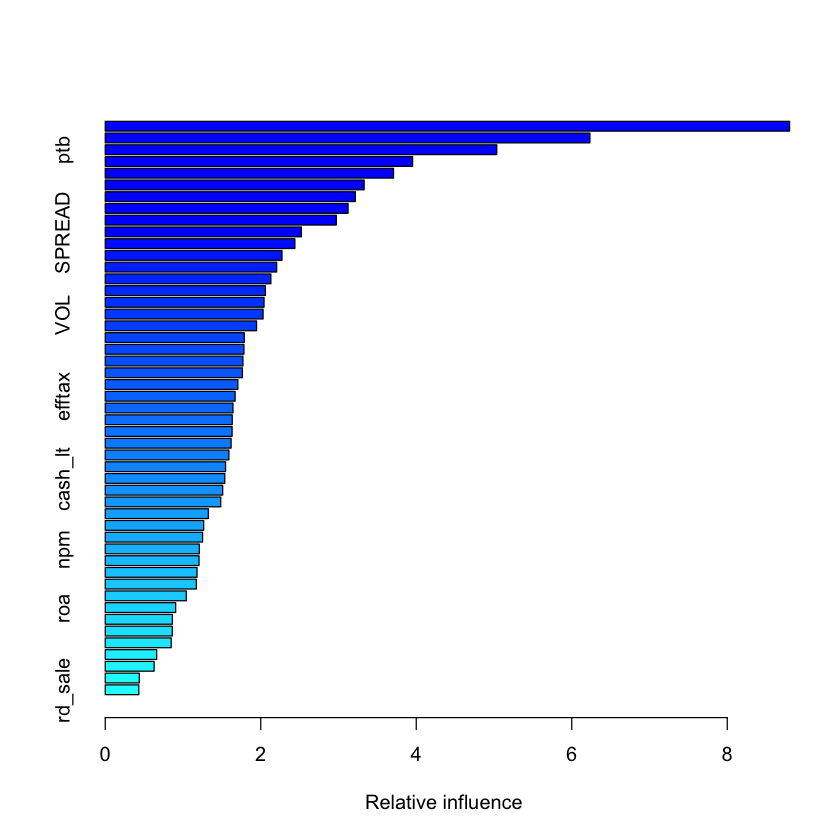

In [14]:
###Task 3###
#Find which covariates are significant for predicting the return of the next month
# Calling the summary() function shows the relative influence of the predictors. 
summary(reg4_tree)